# Adapting MusDB to our strategy

MusDB contains two datasets, both with training and test data.

The first one (4.4 GB) is the one we are using for this baseline. The dataset consists on multiple MP4 files and each source track is located on the MusDB library.

The second one (22.7 GB) already has the source files, so it's a little bit easier to use. 

# Trabalhando com o dataset comprimido 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Importing MusDB library
import musdb|

mus = musdb.DB(root="./musdb-dataset")
mus[0].audio


SyntaxError: invalid syntax (<ipython-input-3-954f6dd51d8e>, line 2)

Each of the songs in 'mus' corresponds to an object with several atributes. Among them, there are the stem atributes that lists each audio stem(0 - mixture, 1 - drumm, 2 - bass, 3 - other, 4 - vocal)

In [4]:
# Writing it in a .wav file to listen each stem of the first song
from scipy.io.wavfile import write

music = mus[0]

write("mus0-mixture.wav", 44100, music.stems[0].astype(np.float32))
write("mus0-drums.wav", 44100, music.stems[1].astype(np.float32))
write("mus0-bass.wav", 44100, music.stems[2].astype(np.float32))
write("mus0-other.wav", 44100, music.stems[3].astype(np.float32))
write("mus0-vocal.wav", 44100, music.stems[4].astype(np.float32))

NameError: name 'mus' is not defined

Let's take a look at the wave plot of the audio, considering only the drums

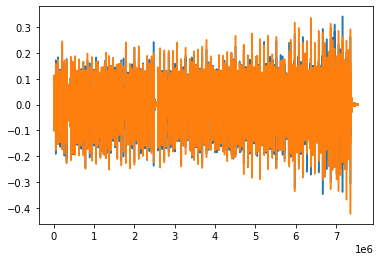

In [8]:
import matplotlib.pyplot as plt

plt.plot(music.stems[1])

Como podemos ver, cada áudio possui dois canais

As we can see, each audio has two channels. We will use only one channel for now, but later we will extend the idea for the two channels considering their mean.

In [9]:
write("mus0-mixture-first-channel.wav", 44100, music.stems[0][:, 0].astype(np.float32))
write("mus0-mixture-second-channel.wav", 44100, music.stems[0][:, 1].astype(np.float32))

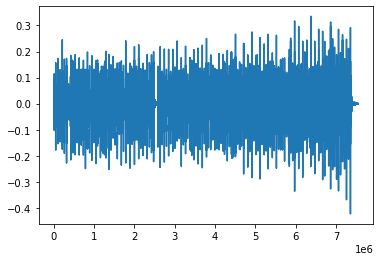

In [10]:
plt.plot(music.stems[1][:,1])

# Creating the spectogram

Now that we have the tracks and their stems, our plan is to create the spectogram for each one of the songs and stems, compute their element-wise division and find out each stem's mask.

## What is the stem mask?

Considering a song $S$ and the drum's stem as $D$, there exists a mask $M$ for which $$D = S \cdot M \quad \text{where }\cdot \text{ corresponds to the Hadamard Product (element-wise)}$$

With that in mind, we have a set of masks that corresponds to the correct outputs for our models to train it (althought we don't know if we are going it's going to be a regression model for the mask ou a binary classification for the mask's elements).

## Primeira tentativa: Scipy

In [11]:
from scipy import signal

# Default values according to MusDB
fs = 44100

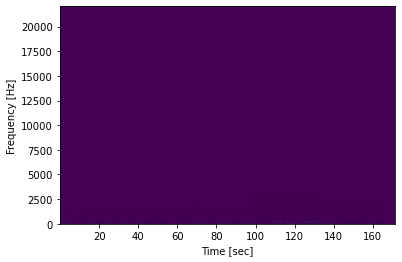

In [16]:
frequency,time,spectrogram = signal.spectrogram(music.stems[0][:,0], fs)
plt.pcolormesh(time, frequencies, spectrogram, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

As we can see, trying to create the spectogram using only the first channel of the mix didn't work out.
Let's try reading the file using wavfile.read from scipy.io

In [65]:
from scipy.io import wavfile

sample_rate, samples = wavfile.read('mus0-mixture-first-channel.wav')
frequencies, time, spectrogram = signal.spectrogram(samples, sample_rate)

print(sample_rate)
print(samples)

44100
[1.4770508e-02 3.2653809e-02 5.3955078e-02 ... 0.0000000e+00 3.0517578e-05
 0.0000000e+00]


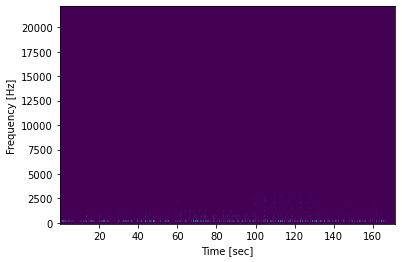

In [66]:
plt.pcolormesh(times, frequencies, spectrogram, shading='nearest')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

Ok, that didn't work out as well.

In the original article about track segmentation, we read about the mel spectogram.

Apparently, in our domain, the frequency values are not quite at a good scale. If we apply a logarithmic function to the frequency scale, we can have a better view (in reality, applying the logarithm is applying some kind of non-linearity to the frequency scale).

Let's try using the mel spectogram.

# Generating the mel spectogram

In [21]:
import librosa
import librosa.display

In [24]:
y, sample_rate = librosa.load("mus0-mixture-first-channel.wav")

In [25]:
print(y)
print(sample_rate)

[ 1.2874756e-02  5.5364706e-02  6.9209658e-02 ... -1.2371465e-06
  9.2890252e-07  1.4524045e-05]
22050


In [98]:
def create_mel_spectrogram(filename):
    y, sr = librosa.load(filename, sr=44100)
    print("sample rate: " + str(sr))
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    return S

def create_mel_plot(S):
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=44100, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')

In [99]:
music_stems = ["mixture", "drumm", "bass", "other", "vocals"]

In [100]:
for i, (stem, stem_name) in enumerate(zip(music.stems, music_stems)):
    filename = "music_" + stem_name + ".wav"
    write(filename, 44100, stem[:, 0].astype(np.float32))

In [101]:
mel_spectrograms = list()
for stem in music_stems:
    mel_spectrograms.append(create_mel_spectrogram("music_" + stem + ".wav"))

sample rate: 44100
sample rate: 44100
sample rate: 44100
sample rate: 44100
sample rate: 44100


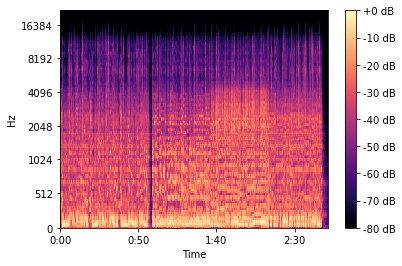

In [102]:
create_mel_plot(mel_spectrograms[0]) # Mixture

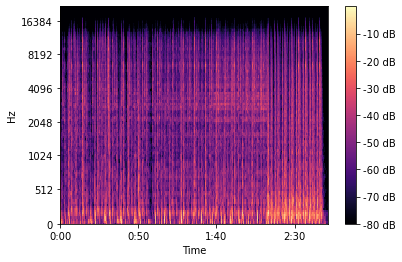

In [103]:
create_mel_plot(mel_spectrograms[1]) # Drumm

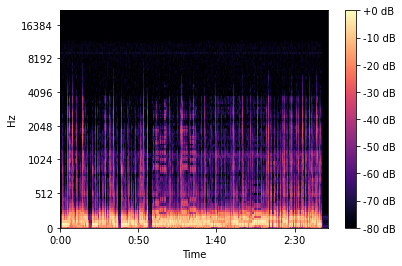

In [104]:
create_mel_plot(mel_spectrograms[2]) # bass

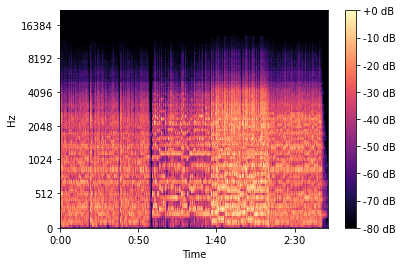

In [105]:
create_mel_plot(mel_spectrograms[3]) # other

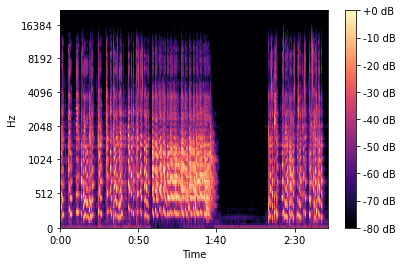

In [106]:
create_mel_plot(mel_spectrograms[4]) # vocal

# Creating the mask

Now that we were able to use the mel spectogram, let's try some reverse engineering techniques.

$$D_i =  S \cdot M_i \text{ tal que }i\text{ corresponde a cada uma das stems (i=[0,4])}$$

At first, we got the $S$ and $D$ relation as $$D_i =  S \cdot M_i \text{ where }i\text{ corresponds to each stem (i=[0,4])}$$

Considering this is an element-wise multiplication, to find out the mask we must apply an element-wise division.


In [107]:
masks = [stem.astype(np.float64) / mel_spectrograms[0] for stem in mel_spectrograms[1:]]
# Remember that mel_spectrograms[0] corresponds to the mix stem (complete song)

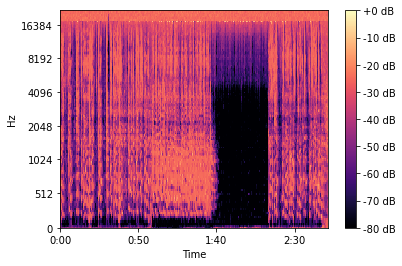

In [108]:
create_mel_plot(masks[3]) # Vocal stem mask

# Validating our results

Since we have the mask, let's try using the element-wise multiplication and check if it's close to the original source.

In [109]:
stems_reconstruction = [ mel_spectrograms[0] * mask for mask in masks]

In [110]:
drumm_audio = librosa.feature.inverse.mel_to_audio(stems_reconstruction[0])

In [111]:
write("target_drumm.wav", 44100, drumm_audio.astype(np.float32))

Aparentemente deu bom, tivemos perda de qualidade, algo pode ser feito para tentarmos melhorar isso.

It turned out good, althought we lost some quality.
Now, we must apply this procedure for the whole train dataset to get our outputs.